In [2]:
import sys
sys.path.append('/mnt/apollo/bare_soil_xuemeng/scikit-map/')

import warnings
# warnings.filterwarnings('ignore')

from skmap.io import read_rasters, save_rasters #, RasterData
from skmap.io import process
from skmap.misc import date_range, ttprint , new_memmap # load_memmap, del_memmap, ref_memmap
from eumap.misc import find_files, nan_percentile, ttprint
# from eumap.raster import read_rasters, save_rasters
import os

from pathlib import Path
from minio import Minio
# from eumap.misc import find_files, nan_percentile
import numpy as np
import gc
import numexpr as ne
import bottleneck as bn

from minio.commonconfig import REPLACE, CopySource
import time as tm
import multiprocess as mp
import geopandas as gpd
import matplotlib.pyplot as plt 
import fiona
from osgeo import gdal

bands = [('blue',1),('green',2),('red',3),('NIR',4),('SWIR1',5),('SWIR2',6),('thermal',7),('qa',8)]
# tiles = ['016E_63N','017E_63N','006W_53N','006W_52N','003E_52N','004E_52N','003E_51N','004E_51N','005E_52N','006E_52N','005E_51N',
#          '006E_51N','023E_52N','007E_46N','008E_46N','009E_44N','010E_44N','023E_38N','024E_38N','023E_37N','004W_36N']
tiles = ['004E_51N','004W_36N','005E_52N','024E_38N'] #['016E_63N', '006W_53N', '003E_52N', '004E_51N',

gdal_opts = {
    'GDAL_HTTP_MULTIRANGE': 'YES',
    'GDAL_HTTP_MERGE_CONSECUTIVE_RANGES': 'YES',
    'GDAL_HTTP_VERSION': '1.0',
    'GDAL_DISABLE_READDIR_ON_OPEN': 'EMPTY_DIR',
    'VSI_CACHE': 'FALSE',
    'CPL_VSIL_CURL_ALLOWED_EXTENSIONS': '.tif',
    'GDAL_HTTP_CONNECTTIMEOUT': '320',
    'CPL_VSIL_CURL_USE_HEAD': 'NO',
    'GDAL_HTTP_TIMEOUT': '320',
    'CPL_CURL_GZIP': 'NO'
}

itvls = []
years = list(np.arange(2000,2022,1))
for year in years:
    for j in np.arange(1,24,1):
        itvls.append((year,(year-1980)*23+j))
        
ddoy = ['001','017','033','049','065','081','097','113','129','145','161','177','193','209','225','241','257','273','289','305','321','337','353']
dioy = list(range(1,24,1))
doy = dict(zip(dioy,ddoy))


In [7]:
s3_config = {
        'access_key': 'iwum9G1fEQ920lYV4ol9',
        'secret_access_key': 'GMBME3Wsm8S7mBXw3U4CNWurkzWMqGZ0n2rXHggS0',
        'host': '192.168.1.30:8333',
        'bucket': 'tmp-bare-soil'}
    
client = Minio(s3_config['host'], s3_config['access_key'], s3_config['secret_access_key'], secure=False)

def list_files(directory):
    ll = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            ll.append(files)
    return ll

def move_command(oper, tile):
    import subprocess
    
    src = f'/mnt/apollo/bare_soil_xuemeng/tmp_files/{oper}/{tile}/'
    tgt = f'gaia/tmp-bare-soil/{oper}/{tile}/'  #http://192.168.1.30:8333
    command = f'mc cp --recursive {src} {tgt}'
    print(command)
    
def check_tile(tile):
    tile = tile.replace('_','.')
    noo = []
    for oper in ['gapfilled','ndti','ndvi','bsi','bsf','los','nos']:
        folder_path = f'/mnt/apollo/bare_soil_xuemeng/tmp_files/{oper}'
        files = find_files(folder_path,f'*{tile}*.tif')
        print(oper,len(files))
        if len(files)==0:
            noo.append(oper)
        else:
            move_command(oper, tile)
    print(tile,noo)
    # for band in bands:
    #     files = [filename for filename in os.listdir(folder_path) if f'{band[0]}' in filename]
    #     print(f'{tile}, {band[0]}: {len(files)}')
    
#     if len(files) == 506:
#         for f in files:
#             client.fput_object(s3_config['bucket'], f'16days/gapfilled/{tile}/{f}', os.path.join(folder_path, f))
#             os.remove(os.path.join(folder_path, f))
        
    return noo




In [8]:
for i in range(4):
    a = check_tile(tiles[i])
# 

gapfilled 0
ndti 506
mc cp --recursive /mnt/apollo/bare_soil_xuemeng/tmp_files/ndti/004E.51N/ gaia/tmp-bare-soil/ndti/004E.51N/
ndvi 506
mc cp --recursive /mnt/apollo/bare_soil_xuemeng/tmp_files/ndvi/004E.51N/ gaia/tmp-bare-soil/ndvi/004E.51N/
bsi 506
mc cp --recursive /mnt/apollo/bare_soil_xuemeng/tmp_files/bsi/004E.51N/ gaia/tmp-bare-soil/bsi/004E.51N/
bsf 22
mc cp --recursive /mnt/apollo/bare_soil_xuemeng/tmp_files/bsf/004E.51N/ gaia/tmp-bare-soil/bsf/004E.51N/
los 22
mc cp --recursive /mnt/apollo/bare_soil_xuemeng/tmp_files/los/004E.51N/ gaia/tmp-bare-soil/los/004E.51N/
nos 22
mc cp --recursive /mnt/apollo/bare_soil_xuemeng/tmp_files/nos/004E.51N/ gaia/tmp-bare-soil/nos/004E.51N/
004E.51N ['gapfilled']
gapfilled 0
ndti 506
mc cp --recursive /mnt/apollo/bare_soil_xuemeng/tmp_files/ndti/004W.36N/ gaia/tmp-bare-soil/ndti/004W.36N/
ndvi 506
mc cp --recursive /mnt/apollo/bare_soil_xuemeng/tmp_files/ndvi/004W.36N/ gaia/tmp-bare-soil/ndvi/004W.36N/
bsi 506
mc cp --recursive /mnt/apollo/ba

In [46]:
itvl = itvls[0]
inputs = [f'http://192.168.1.30:8333/landsat-ard2/{itvl[0]}/{tile}/{itvl[1]}.tif' for tile in tiles]
output = f'/mnt/primus/xuemeng_tmp_harbour/crop_bare_index/tmp_files/vrt/landsat_{itvl[0]}{doy.get(itvl[1]-(itvl[0]-1980)*23)}.vrt'

vrt_options = gdal.BuildVRTOptions(resampleAlg='cubic', addAlpha=True)
a = gdal.BuildVRT(output, inputs, options = vrt_options)
# a.FlushCache()
print(a)

None


In [ ]:
f'mc cp --recursive gaia/landsat-ard2/{year}/{tile}/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/{tile}/'

In [24]:
import os
os.environ["PATH"] += os.pathsep + "/home/opengeohub/minio-binaries//mc"


Executing: mc cp --recursive gaia/landsat-ard2/2000/016E_63N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/016E_63N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2000/006W_53N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006W_53N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2000/003E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/003E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2000/004E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004E_51N/
Executing: mc cp --recursive gaia/landsat-ard2/2000/005E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/005E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2000/006E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006E_51N/
Executing: mc cp --recursive gaia/landsat-ard2/2000/023E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/023E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2000/007E_46N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/007E_46N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2000/024E_38N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/024E_38N/
Executing: mc cp --recursive gaia/landsat-ard2/2000/004W_36N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004W_36N/
Executing: mc cp --recursive gaia/landsat-ard2/2001/016E_63N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/016E_63N/
Executing: mc cp --recursive gaia/landsat-ard2/2001/006W_53N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006W_53N/
Executing: mc cp --recursive gaia/landsat-ard2/2001/003E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/003E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2001/004E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004E_51N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2001/005E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/005E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2001/006E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006E_51N/
Executing: mc cp --recursive gaia/landsat-ard2/2001/023E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/023E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2001/007E_46N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/007E_46N/
Executing: mc cp --recursive gaia/landsat-ard2/2001/024E_38N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/024E_38N/
Executing: mc cp --recursive gaia/landsat-ard2/2001/004W_36N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004W_36N/
Executing: mc cp --recursive gaia/landsat-ard2/2002/016E_63N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/016E_63N/
Executing: mc cp --recursive gaia/landsat-ard2/2002/006W_53N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006W_53N/
Executing: mc cp --recursive gai

bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2002/006E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006E_51N/
Executing: mc cp --recursive gaia/landsat-ard2/2002/023E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/023E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2002/007E_46N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/007E_46N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2002/024E_38N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/024E_38N/
Executing: mc cp --recursive gaia/landsat-ard2/2002/004W_36N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004W_36N/
Executing: mc cp --recursive gaia/landsat-ard2/2003/016E_63N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/016E_63N/
Executing: mc cp --recursive gaia/landsat-ard2/2003/006W_53N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006W_53N/
Executing: mc cp --recursive gaia/landsat-ard2/2003/003E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/003E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2003/004E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004E_51N/
Executing: mc cp --recursive gaia/landsat-ard2/2003/005E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/005E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2003/006E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006E_51N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2003/023E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/023E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2003/007E_46N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/007E_46N/
Executing: mc cp --recursive gaia/landsat-ard2/2003/024E_38N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/024E_38N/
Executing: mc cp --recursive gaia/landsat-ard2/2003/004W_36N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004W_36N/
Executing: mc cp --recursive gaia/landsat-ard2/2004/016E_63N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/016E_63N/
Executing: mc cp --recursive gaia/landsat-ard2/2004/006W_53N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006W_53N/
Executing: mc cp --recursive gaia/landsat-ard2/2004/003E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/003E_52N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2004/004E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004E_51N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2004/005E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/005E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2004/006E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006E_51N/
Executing: mc cp --recursive gaia/landsat-ard2/2004/023E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/023E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2004/007E_46N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/007E_46N/
Executing: mc cp --recursive gaia/landsat-ard2/2004/024E_38N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/024E_38N/
Executing: mc cp --recursive gaia/landsat-ard2/2004/004W_36N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004W_36N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2005/016E_63N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/016E_63N/
Executing: mc cp --recursive gaia/landsat-ard2/2005/006W_53N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006W_53N/
Executing: mc cp --recursive gaia/landsat-ard2/2005/003E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/003E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2005/004E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004E_51N/
Executing: mc cp --recursive gaia/landsat-ard2/2005/005E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/005E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2005/006E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006E_51N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2005/023E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/023E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2005/007E_46N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/007E_46N/
Executing: mc cp --recursive gaia/landsat-ard2/2005/024E_38N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/024E_38N/
Executing: mc cp --recursive gaia/landsat-ard2/2005/004W_36N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004W_36N/
Executing: mc cp --recursive gaia/landsat-ard2/2006/016E_63N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/016E_63N/
Executing: mc cp --recursive gaia/landsat-ard2/2006/006W_53N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006W_53N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2006/003E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/003E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2006/004E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004E_51N/
Executing: mc cp --recursive gaia/landsat-ard2/2006/005E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/005E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2006/006E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006E_51N/
Executing: mc cp --recursive gaia/landsat-ard2/2006/023E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/023E_52N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2006/007E_46N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/007E_46N/
Executing: mc cp --recursive gaia/landsat-ard2/2006/024E_38N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/024E_38N/
Executing: mc cp --recursive gaia/landsat-ard2/2006/004W_36N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004W_36N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2007/016E_63N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/016E_63N/
Executing: mc cp --recursive gaia/landsat-ard2/2007/006W_53N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006W_53N/
Executing: mc cp --recursive gaia/landsat-ard2/2007/003E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/003E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2007/004E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004E_51N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2007/005E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/005E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2007/006E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006E_51N/
Executing: mc cp --recursive gaia/landsat-ard2/2007/023E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/023E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2007/007E_46N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/007E_46N/
Executing: mc cp --recursive gaia/landsat-ard2/2007/024E_38N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/024E_38N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2007/004W_36N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004W_36N/
Executing: mc cp --recursive gaia/landsat-ard2/2008/016E_63N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/016E_63N/
Executing: mc cp --recursive gaia/landsat-ard2/2008/006W_53N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006W_53N/
Executing: mc cp --recursive gaia/landsat-ard2/2008/003E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/003E_52N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2008/004E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004E_51N/
Executing: mc cp --recursive gaia/landsat-ard2/2008/005E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/005E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2008/006E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006E_51N/
Executing: mc cp --recursive gaia/landsat-ard2/2008/023E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/023E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2008/007E_46N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/007E_46N/
Executing: mc cp --recursive gaia/landsat-ard2/2008/024E_38N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/024E_38N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2008/004W_36N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004W_36N/
Executing: mc cp --recursive gaia/landsat-ard2/2009/016E_63N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/016E_63N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2009/006W_53N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006W_53N/
Executing: mc cp --recursive gaia/landsat-ard2/2009/003E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/003E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2009/004E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004E_51N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2009/005E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/005E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2009/006E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006E_51N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2009/023E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/023E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2009/007E_46N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/007E_46N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2009/024E_38N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/024E_38N/
Executing: mc cp --recursive gaia/landsat-ard2/2009/004W_36N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004W_36N/
Executing: mc cp --recursive gaia/landsat-ard2/2010/016E_63N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/016E_63N/
Executing: mc cp --recursive gaia/landsat-ard2/2010/006W_53N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006W_53N/
Executing: mc cp --recursive gaia/landsat-ard2/2010/003E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/003E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2010/004E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004E_51N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2010/005E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/005E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2010/006E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006E_51N/
Executing: mc cp --recursive gaia/landsat-ard2/2010/023E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/023E_52N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2010/007E_46N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/007E_46N/
Executing: mc cp --recursive gaia/landsat-ard2/2010/024E_38N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/024E_38N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2010/004W_36N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004W_36N/
Executing: mc cp --recursive gaia/landsat-ard2/2011/016E_63N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/016E_63N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2011/006W_53N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006W_53N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2011/003E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/003E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2011/004E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004E_51N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2011/005E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/005E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2011/006E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006E_51N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2011/023E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/023E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2011/007E_46N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/007E_46N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2011/024E_38N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/024E_38N/
Executing: mc cp --recursive gaia/landsat-ard2/2011/004W_36N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004W_36N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2012/016E_63N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/016E_63N/
Executing: mc cp --recursive gaia/landsat-ard2/2012/006W_53N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006W_53N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2012/003E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/003E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2012/004E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004E_51N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2012/005E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/005E_52N/
Executing: mc cp --recursive gaia/landsat-ard2/2012/006E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006E_51N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2012/023E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/023E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2012/007E_46N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/007E_46N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2012/024E_38N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/024E_38N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2012/004W_36N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004W_36N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2013/016E_63N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/016E_63N/
Executing: mc cp --recursive gaia/landsat-ard2/2013/006W_53N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006W_53N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2013/003E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/003E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2013/004E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004E_51N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2013/005E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/005E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2013/006E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006E_51N/
Executing: mc cp --recursive gaia/landsat-ard2/2013/023E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/023E_52N/


bash: line 13: mc: command not found
bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2013/007E_46N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/007E_46N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2013/024E_38N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/024E_38N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2013/004W_36N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004W_36N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2014/016E_63N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/016E_63N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2014/006W_53N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006W_53N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2014/003E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/003E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2014/004E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004E_51N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2014/005E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/005E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2014/006E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006E_51N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2014/023E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/023E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2014/007E_46N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/007E_46N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2014/024E_38N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/024E_38N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2014/004W_36N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004W_36N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2015/016E_63N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/016E_63N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2015/006W_53N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006W_53N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2015/003E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/003E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2015/004E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004E_51N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2015/005E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/005E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2015/006E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006E_51N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2015/023E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/023E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2015/007E_46N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/007E_46N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2015/024E_38N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/024E_38N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2015/004W_36N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004W_36N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2016/016E_63N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/016E_63N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2016/006W_53N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006W_53N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2016/003E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/003E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2016/004E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004E_51N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2016/005E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/005E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2016/006E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006E_51N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2016/023E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/023E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2016/007E_46N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/007E_46N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2016/024E_38N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/024E_38N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2016/004W_36N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004W_36N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2017/016E_63N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/016E_63N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2017/006W_53N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006W_53N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2017/003E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/003E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2017/004E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004E_51N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2017/005E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/005E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2017/006E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006E_51N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2017/023E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/023E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2017/007E_46N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/007E_46N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2017/024E_38N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/024E_38N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2017/004W_36N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004W_36N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2018/016E_63N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/016E_63N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2018/006W_53N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006W_53N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2018/003E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/003E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2018/004E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004E_51N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2018/005E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/005E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2018/006E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006E_51N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2018/023E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/023E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2018/007E_46N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/007E_46N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2018/024E_38N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/024E_38N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2018/004W_36N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004W_36N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2019/016E_63N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/016E_63N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2019/006W_53N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006W_53N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2019/003E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/003E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2019/004E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004E_51N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2019/005E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/005E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2019/006E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006E_51N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2019/023E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/023E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2019/007E_46N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/007E_46N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2019/024E_38N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/024E_38N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2019/004W_36N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004W_36N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2020/016E_63N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/016E_63N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2020/006W_53N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006W_53N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2020/003E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/003E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2020/004E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004E_51N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2020/005E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/005E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2020/006E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006E_51N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2020/023E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/023E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2020/007E_46N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/007E_46N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2020/024E_38N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/024E_38N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2020/004W_36N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004W_36N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2021/016E_63N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/016E_63N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2021/006W_53N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006W_53N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2021/003E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/003E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2021/004E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004E_51N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2021/005E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/005E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2021/006E_51N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/006E_51N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2021/023E_52N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/023E_52N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2021/007E_46N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/007E_46N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2021/024E_38N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/024E_38N/


bash: line 13: mc: command not found


Executing: mc cp --recursive gaia/landsat-ard2/2021/004W_36N/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/004W_36N/


bash: line 13: mc: command not found


CalledProcessError: Command 'b'\n# Define lists of years and tiles\nyears=(\'2000\' \'2001\' \'2002\' \'2003\' \'2004\' \'2005\' \'2006\' \'2007\' \'2008\' \'2009\' \'2010\' \'2011\' \'2012\'\n       \'2013\' \'2014\' \'2015\' \'2016\' \'2017\' \'2018\' \'2019\' \'2020\' \'2021\')\ntiles=(\'016E_63N\' \'006W_53N\' \'003E_52N\' \'004E_51N\' \'005E_52N\' \'006E_51N\' \'023E_52N\' \'007E_46N\' \'024E_38N\' \'004W_36N\')\n\n# Iterate over each combination of year and tile\nfor year in "${years[@]}"; do\n    for tile in "${tiles[@]}"; do\n        # Construct and execute the mc cp command\n        cmd="mc cp --recursive gaia/landsat-ard2/${year}/${tile}/ /mnt/apollo/bare_soil_xuemeng/tmp_files/original/${tile}/"\n        echo "Executing: $cmd"\n        $cmd\n    done\ndone\n\n\n'' returned non-zero exit status 127.

In [52]:
# # old version applied on files with right names

# def worker_gapfill(ts,bs,period):
    
#     if period == 'monthly':
#         ks = 1
#         out_f = f'/mnt/tupi/Xuemeng_testing/{period}_gapfilled/landsat_{bs}_{ts}_2021335.tif'
#     else:
#         ks = 2
#         out_f = f'/mnt/tupi/Xuemeng_testing/{period}_gapfilled/landsat_{bs}_{ts}_2021305.tif'
        
#     print(out_f)
#     if os.path.exists(out_f):
#         print(f'{period}_{bs}_{ts} exists!')
#         return None
#     else:
#         print(f'{period}_{bs}_{ts} generating...')
    
#     group = {f'{bs}': f'http://192.168.1.30:8333/tmp-bare-soil/landsat_{period}/{bs}_landsat.{ts}_p50_'+'{dt}.tif'}
    
        
#     rdata = RasterData(group,verbose=True) \
#     .timespan('2000001', '2021336', date_step=23, date_unit='days', date_format='%Y%j', date_style='start_date', ignore_29feb=True) \
#     .read()
    
#     outn = 'landsat_{gr}_'+f'{ts}' + '_{dt}'
#     base_raster_path = rdata._base_raster()
#     rdata = rdata.run(process.SeasConvFill(season_size=1), outname=outn, drop_input=True).rename(groups= {'{gr}..p50': '{gr}'})
#     rdata.info['input_path'] = base_raster_path
#     rdata.to_dir(f'{period}_gapfilled')
    
#     return None

# inputs = []
# for period in ['monthly']:
#     for bs in bands:
#         for ts in tile_ids:
#             inputs.append((ts,bs,period))
            
# # with mp.Pool(processes=3) as pool:
# #     result = pool.starmap(worker_gapfill, inputs)

# for i in inputs:
#     # print(i)
#     worker_gapfill(i[0],i[1],i[2])

In [42]:
# # examples from Leandro
# from skmap.data import toy
# from skmap.io import process

# # Loading NDVI quarterly time-series with gaps
# toy.ndvi_rdata(gappy=True 
#     # Gapfilling time-series by seasonal convolution 
#     ).run(process.SeasConvFill(season_size=4), drop_input=True
#     # Smoothing time-series by Whittaker
#     ).run(process.WhittakerSmooth(), group='ndvi.seasconv', drop_input=True
#     # Setting smoothed time-series as main input
#     ).rename(groups={'ndvi.seasconv.whittaker': 'ndvi'}
#     # Running yearly aggregation by std. and percentile 50th
#     ).run(process.TimeAggregate(time=[process.TimeEnum.YEARLY], operations = ['p50', 'std']), group=['ndvi']
#     # Running trend analysis using per-pixel linear regression  
#     ).run(process.TrendAnalysis(season_size=4), group='ndvi'
#     # Ploting all raster data
#     ).plot(v_minmax=[0,100])

In [18]:
# # # get the landsat tile ids that overlay with the fid chosen by Martijn
# eu = gpd.read_file('/mnt/primus/xuemeng_tmp_harbour/crop_bare_index/eu_tilling_system_30km.gpkg') #http://192.168.1.30:8333/tmp-bare-soil/eu_tilling_system_30km.gpkg
# landsat = gpd.read_file('/mnt/primus/xuemeng_tmp_harbour/crop_bare_index/glad_landsat_tiles.gpkg')

# # get fid id of tiles chosen by Martijn 
# with fiona.open('/mnt/primus/xuemeng_tmp_harbour/crop_bare_index/eu_tilling_system_30km.gpkg') as f:
#     feats = list(f)
#     fids = [f['id'] for f in feats]
# eu['id'] = fids
# eu['id'] = eu['id'].astype(int)

# eu_tile = [22497,16057,14576,14580,15560,10636,9326,9629,5606,4582]
# euc = eu[eu['id'].isin(eu_tile)]

# euc = euc.to_crs(epsg=4326)
# lap = gpd.sjoin(landsat, euc, how="inner", op="intersects")
# lap.to_file('/mnt/primus/xuemeng_tmp_harbour/crop_bare_index/overlay_10_test_tiles.gpkg', driver='GPKG')
# euc.to_file('/mnt/primus/xuemeng_tmp_harbour/crop_bare_index/eu_10_test_tiles.gpkg', driver='GPKG')
# # result['TILE'].values.tolist()

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


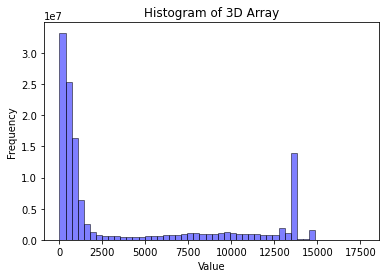

In [42]:

# hist, bins = np.histogram(rdata.flatten(), bins=50)  # Adjust the number of bins as needed
# plt.hist(rdata.flatten(), bins=50, alpha=0.5, color='b', edgecolor='black')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Histogram')
# plt.show()